In [1]:
# Authors: Jeroen BUil
# License: BSD-3-Clause

# 1. Exploratory Data Analysis

### About:
This notebook is created to explore the database for the dEEGtal coding task.<br>

It leans heavily on the MNE package and additional functions are written to fix/clean up/enrich its features.<br>
Furthermore it batch processes the raw EEG recordings that are delivered to prepare them for the Model Building (Notebook #2).

**Note: This notebook must be run before building models**: Essential file(s) are created in the subsequent steps.

# Init

In [2]:
import glob as glob
import pickle
import time
import numpy as np
import matplotlib.pyplot as plt
import mne
import pandas as pd

from IPython.display import clear_output

import os, sys
from pathlib import Path

# Force add module to sys path as it is sometimes not recognised
module_path = os.path.abspath(os.path.join("..")) + "/deegtal_coding_task"
if module_path not in sys.path:
    sys.path.append(module_path)

from config import *

from mne.viz import set_browser_backend

set_browser_backend("matplotlib")

2024-10-27 17:06:32.477 | INFO     | config:<module>:11 - PROJ_ROOT path is: D:\Files\Projects\Code\deegtal_coding_task


Using matplotlib as 2D backend.


In [3]:
# Create folders
# Create group folders for data storage if they don't exist already
Path(INTERIM_DATA_DIR).mkdir(parents=True, exist_ok=True)
Path(PROCESSED_DATA_DIR).mkdir(parents=True, exist_ok=True)

In [4]:
# When processing all the EEG recordings figures are generated of the channel voltages and the freq spectrums to check for anomalies. These can be stored in a seperate folder if desired to later view back.
save_figs = True  # Set to False if you don't want to store the figures

# Load data

In [5]:
folder_raw_group_1 = RAW_DATA_DIR / "Group1"
folder_raw_group_2 = RAW_DATA_DIR / "Group2"

files_raw_group_1 = list(folder_raw_group_1.glob("*.edf"))
files_raw_group_2 = list(folder_raw_group_2.glob("*.edf"))

files_raw = [files_raw_group_1, files_raw_group_2]
print(files_raw[0], "\n", files_raw[1])

[WindowsPath('D:/Files/Projects/Code/deegtal_coding_task/data/raw/Group1/1_1.edf'), WindowsPath('D:/Files/Projects/Code/deegtal_coding_task/data/raw/Group1/1_2.edf'), WindowsPath('D:/Files/Projects/Code/deegtal_coding_task/data/raw/Group1/1_3.edf'), WindowsPath('D:/Files/Projects/Code/deegtal_coding_task/data/raw/Group1/1_4.edf'), WindowsPath('D:/Files/Projects/Code/deegtal_coding_task/data/raw/Group1/1_5.edf')] 
 [WindowsPath('D:/Files/Projects/Code/deegtal_coding_task/data/raw/Group2/2_1.edf'), WindowsPath('D:/Files/Projects/Code/deegtal_coding_task/data/raw/Group2/2_2.edf'), WindowsPath('D:/Files/Projects/Code/deegtal_coding_task/data/raw/Group2/2_3.edf'), WindowsPath('D:/Files/Projects/Code/deegtal_coding_task/data/raw/Group2/2_4.edf'), WindowsPath('D:/Files/Projects/Code/deegtal_coding_task/data/raw/Group2/2_5.edf')]


In [6]:
# Preview unprocessed data
raw = mne.io.read_raw_edf(files_raw[0][3], preload=True)
print(raw)
print(raw.info)

Extracting EDF parameters from D:\Files\Projects\Code\deegtal_coding_task\data\raw\Group1\1_4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 318749  =      0.000 ...  1274.996 secs...
<RawEDF | 1_4.edf, 30 x 318750 (1275.0 s), ~73.0 MB, data loaded>
<Info | 8 non-empty values
 bads: []
 ch_names: EEG FP1-REF, EEG FP2-REF, EEG F3-REF, EEG F4-REF, EEG C3-REF, ...
 chs: 30 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: 2012-01-01 00:00:00 UTC
 nchan: 30
 projs: []
 sfreq: 250.0 Hz
 subject_info: 3 items (dict)
>


## Fix channel names + assign types

The channel numbers of the recordings don't exactly follow 10-20 montage standard. I wrote a function to set the channel names + types so MNE can handle them nicer.

In [7]:
raw.info["ch_names"]

['EEG FP1-REF',
 'EEG FP2-REF',
 'EEG F3-REF',
 'EEG F4-REF',
 'EEG C3-REF',
 'EEG C4-REF',
 'EEG P3-REF',
 'EEG P4-REF',
 'EEG O1-REF',
 'EEG O2-REF',
 'EEG F7-REF',
 'EEG F8-REF',
 'EEG T3-REF',
 'EEG T4-REF',
 'EEG T5-REF',
 'EEG T6-REF',
 'EEG A1-REF',
 'EEG A2-REF',
 'EEG FZ-REF',
 'EEG CZ-REF',
 'EEG PZ-REF',
 'EEG ROC-REF',
 'EEG LOC-REF',
 'EEG EKG1-REF',
 'EEG T1-REF',
 'EEG T2-REF',
 'PHOTIC-REF',
 'IBI',
 'BURSTS',
 'SUPPR']

In [8]:
mne.channels.get_builtin_montages(descriptions=True)
# It's likely based on the standard_1020, but some channel names are named different

[('standard_1005',
  'Electrodes are named and positioned according to the international 10-05 system (343+3 locations)'),
 ('standard_1020',
  'Electrodes are named and positioned according to the international 10-20 system (94+3 locations)'),
 ('standard_alphabetic',
  'Electrodes are named with LETTER-NUMBER combinations (A1, B2, F4, …) (65+3 locations)'),
 ('standard_postfixed',
  'Electrodes are named according to the international 10-20 system using postfixes for intermediate positions (100+3 locations)'),
 ('standard_prefixed',
  'Electrodes are named according to the international 10-20 system using prefixes for intermediate positions (74+3 locations)'),
 ('standard_primed',
  "Electrodes are named according to the international 10-20 system using prime marks (' and '') for intermediate positions (100+3 locations)"),
 ('biosemi16', 'BioSemi cap with 16 electrodes (16+3 locations)'),
 ('biosemi32', 'BioSemi cap with 32 electrodes (32+3 locations)'),
 ('biosemi64', 'BioSemi cap w

In [9]:
def fix_channel_names(raw: mne.io.edf.edf.RawEDF) -> mne.io.edf.edf.RawEDF:
    """This function converts the channel names to standard_1020 so that MNE:
    - can read it in properly and assign sensor locations
    - can assign EPOCHs to the stim channel

    ARG:
    - raw = MNE raw file as they are provided by dEEGtal for their coding task

    RETURN:
    - MNE raw file with standard_1020 ch_names
    """

    correct_ch_names = {}

    if len(raw.info["ch_names"]) == 36:
        raw.set_channel_types(
            {
                "EMG-REF": "emg",
                "PHOTIC-REF": "stim",
                "IBI": "stim",
                "BURSTS": "stim",
                "SUPPR": "stim",
                "EEG T1-REF": "eog",
                "EEG T2-REF": "eog",
                "EEG ROC-REF": "eog",
                "EEG LOC-REF": "eog",
                "EEG 26-REF": "misc",
                "EEG 27-REF": "misc",
                "EEG 28-REF": "misc",
                "EEG 29-REF": "misc",
                "EEG 30-REF": "misc",
                "EEG EKG1-REF": "ecg",
            }
        )

    elif len(raw.info["ch_names"]) == 30:
        raw.set_channel_types(
            {
                "PHOTIC-REF": "stim",
                "IBI": "stim",
                "BURSTS": "stim",
                "SUPPR": "stim",
                "EEG T1-REF": "eog",
                "EEG T2-REF": "eog",
                "EEG ROC-REF": "eog",
                "EEG LOC-REF": "eog",
                "EEG EKG1-REF": "ecg",
            }
        )
    else:
        raise ValueError(
            "raw contains neither 30 nor 36 channels, this function cannot handle those cases"
        )

    for i, ch_name in enumerate(raw.info.ch_names):
        if mne.channel_type(raw.info, i) != "eeg":
            continue

        if ch_name[4:-4] in ["FP1", "FP2", "FZ", "CZ", "PZ"]:
            corr = ch_name[4:-4]
            if len(corr) == 3:
                correct_ch_names[ch_name] = corr[0] + corr[1].lower() + corr[2]
            elif len(corr) == 2:
                correct_ch_names[ch_name] = corr[0] + corr[1].lower()

        else:
            correct_ch_names[ch_name] = ch_name[4:-4]

    montage = mne.channels.make_standard_montage("standard_1020")
    raw.rename_channels(correct_ch_names)
    raw.set_montage(montage)

    return raw

Effective window size : 8.192 (s)
Plotting power spectral density (dB=True).


C:\Users\jeroe\AppData\Local\Temp\ipykernel_4092\4173742.py:3: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.compute_psd(fmax=50).plot(picks="data", exclude="bads", amplitude=False)
d:\Files\Projects\Code\deegtal_coding_task\.venv\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


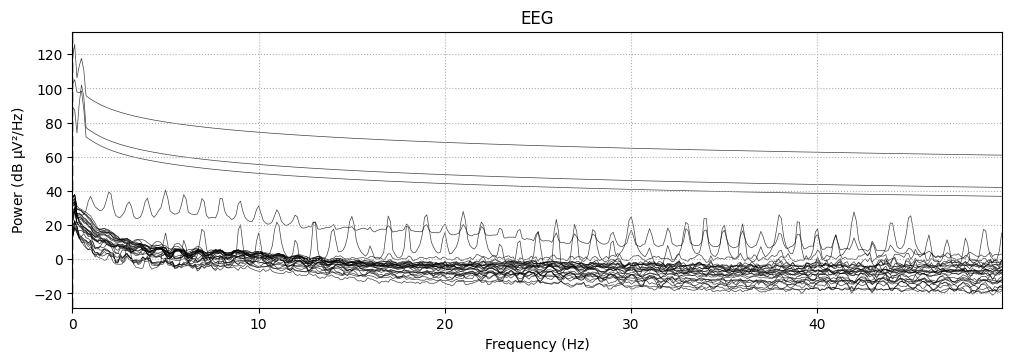

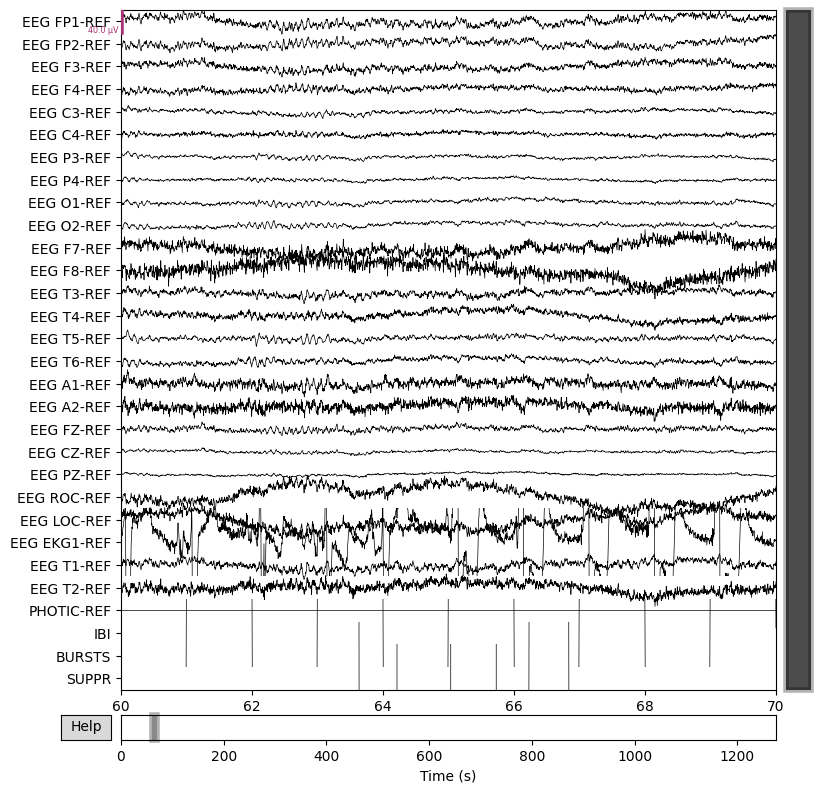

Effective window size : 8.192 (s)
Plotting power spectral density (dB=True).


d:\Files\Projects\Code\deegtal_coding_task\.venv\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


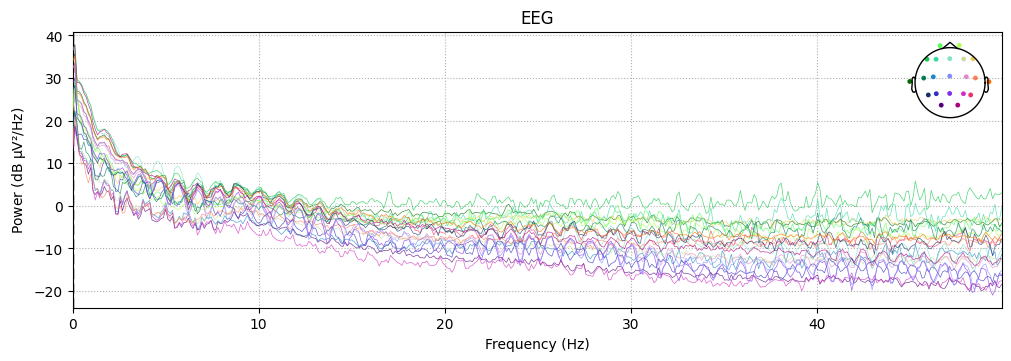

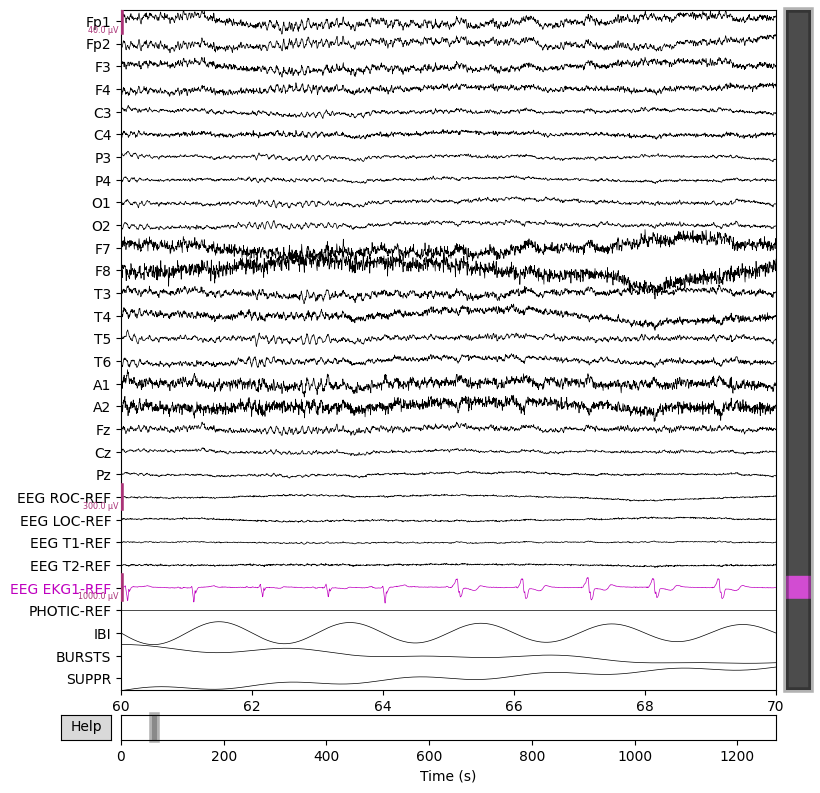

EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Effective window size : 8.192 (s)
Plotting power spectral density (dB=True).


C:\Users\jeroe\AppData\Local\Temp\ipykernel_4092\4173742.py:15: UserWarning: Zero value in spectrum for channel Cz
  rereferenced_raw.compute_psd(fmax=50).plot(picks="eeg", exclude=["Cz"], amplitude=False)
d:\Files\Projects\Code\deegtal_coding_task\.venv\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


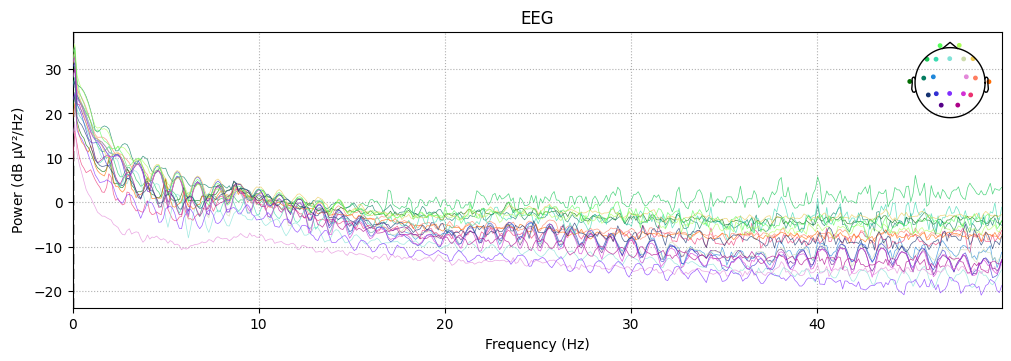

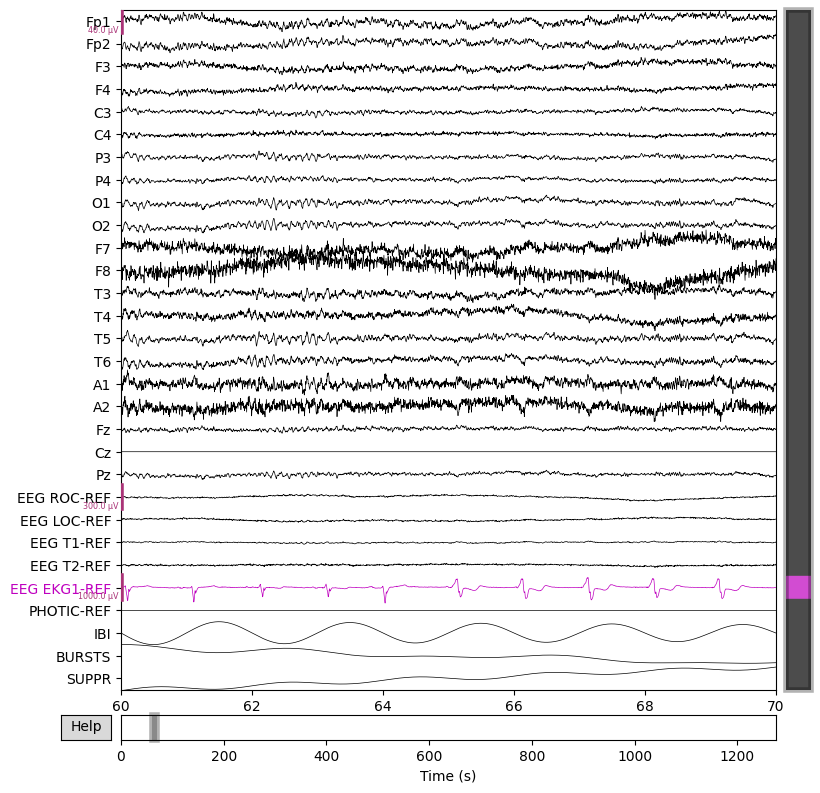

In [10]:
# Plot Unmodified Raw
with mne.viz.use_browser_backend("matplotlib"):
    raw.compute_psd(fmax=50).plot(picks="data", exclude="bads", amplitude=False)
    raw.plot(n_channels=36, start=60)

# Fix channel names and plot again
raw = fix_channel_names(raw=raw)
with mne.viz.use_browser_backend("matplotlib"):
    raw.compute_psd(fmax=50).plot(picks="eeg", exclude="bads", amplitude=False)
    raw.plot(n_channels=36, start=60)

# Rereference and plot again
rereferenced_raw, ref_data = mne.set_eeg_reference(raw, ["Cz"], copy=True)
with mne.viz.use_browser_backend("matplotlib"):
    rereferenced_raw.compute_psd(fmax=50).plot(picks="eeg", exclude=["Cz"], amplitude=False)
    rereferenced_raw.plot(n_channels=36, start=60)

## Set bads 
(not used)

In [11]:
def set_bads(raw: mne.io.edf.edf.RawEDF, bad_ch: list) -> mne.io.edf.edf.RawEDF:
    """This function sets the bad channels for the channels provided by dEEGtal for their coding task

    ARG:
    - raw = MNE raw file

    RETURN:
    - MNE raw file with bad channels assigned to them
    """
    # Add bads
    raw.info["bads"] = bad_ch

    return raw

# Explore Stim channels

Some PHOTIC-REF channels seem to contain a pulse train => explore this further

In [13]:
n_groups = 2
n_recordings = 4
for iGroup in range(n_groups):
    for iSample in range(n_recordings):
        with mne.viz.use_browser_backend("qt"):
            # fig_psd = raw.compute_psd(fmax=120).plot(picks="eeg", exclude="bads", amplitude=False)
            fig_raw = (
                mne.io.read_raw_edf(files_raw[iGroup][iSample])
                .load_data()
                .plot(start=15 * 60, duration=60, picks=["PHOTIC-REF", "IBI", "BURSTS"])
            )
        clear_output()

time.sleep(
    3
)  # add a few sec. delay to let QT finish loading. Otherwise you get explorer not responding messages when it immediately proceeds to execute the next cells.
print("done")

done


In [14]:
# Loop over all recordings for group 1 and group 2 and calc the
table = {}


index = 0


for iGroup in range(2):

    for iSample in range(5):

        raw = mne.io.read_raw_edf(files_raw[iGroup][iSample])

        data, times = raw.pick(["PHOTIC-REF", "IBI", "BURSTS"])[:]

        channels = ["PHOTIC-REF", "IBI", "BURSTS"]

        for i in range(3):

            table[index] = {
                "Group": iGroup + 1,
                "Recording": iSample + 1,
                "Channel": channels[i],
                "Mean": np.mean(data[i, :]),
                "Std": np.std(data[i, :]),
            }

            index += 1

        clear_output()

pd.DataFrame(data=table).T.sort_values(["Channel", "Group", "Recording"]).reset_index(drop=True)

,Group,Recording,Channel,Mean,Std
0,1,1,BURSTS,0.339228,0.53042
1,1,2,BURSTS,0.0,0.0
2,1,3,BURSTS,0.0,0.0
3,1,4,BURSTS,0.392392,0.658648
4,1,5,BURSTS,0.680574,0.528815
5,2,1,BURSTS,0.237873,0.584785
6,2,2,BURSTS,0.0,0.0
7,2,3,BURSTS,0.0,0.0
8,2,4,BURSTS,0.0,0.0
9,2,5,BURSTS,0.0,0.0


## Get Epochs
(not used => not all recordings contain pulse trains in PHOTIC-REF channel)

In [15]:
from scipy.signal import find_peaks


def get_epochs_from_photic_stimuli_train_events(
    raw: mne.io.edf.edf.RawEDF,
    stim_ch: str,
    pulse_train_duration_s: float | int = 10,
    tmin: float = -0.2,
    tmax: float = 10.5,
) -> mne.epochs.Epochs:
    """This function detects spike train events using scipy find_peaks and turns them into epochs

    ARG:
    - raw: MNE raw file
    - stim_ch: name of stimulus channel
    - pulse_train_duration_s: length of the pulse/spike train (this prevents each spike to be registered as event)
    - tmin:  Start of epoch time window before the event
    - tmax:  End of epoch time window after the event

    RETURN:
    - mne Epoch
    """
    # Get Fs from raw
    fs = raw.info["sfreq"]

    # Extract the PHOTIC-REF channel data
    phot_data, times = raw[stim_ch]

    # Set a threshold to detect spikes
    threshold = np.mean(phot_data) + 3 * np.std(phot_data)

    # Detect peaks (spikes)
    peaks, _ = find_peaks(
        phot_data[0], height=threshold, distance=pulse_train_duration_s * fs
    )  # Adjust 'distance' based on your expected pulse train duration

    # Convert peak indices to event times
    event_times = times[peaks]

    # Convert peak indices to sample indices
    peak_samples = raw.time_as_index(event_times)

    # Create events array: [sample, 0, event_id]
    event_id = 1  # Define your event ID (e.g., 1 for photic stimulus)
    events = np.column_stack(
        (
            peak_samples,
            np.zeros(len(peak_samples), dtype=int),
            np.ones(len(peak_samples), dtype=int) * event_id,
        )
    )

    # Create epochs
    epochs = mne.Epochs(
        raw,
        events,
        picks="eeg",
        event_id=event_id,
        tmin=tmin,
        tmax=tmax,
        baseline=(None, 0),
        preload=True,
    )

    return epochs

In [16]:
# epochs = get_epochs_from_photic_stimuli_train_events(raw=raw, stim_ch='PHOTIC-REF', pulse_train_duration_s=10, tmin=-0.2, tmax=10.5)

# with mne.viz.use_browser_backend('qt'):
#     epochs.plot()

## Filter EEG

Function to set the desired filters with one command

In [17]:
def filter_raw_eeg(
    raw: mne.io.edf.edf.RawEDF,
    l_freq: float,
    h_freq: float,
    powerline_freq: int | float | None = None,
) -> mne.io.edf.edf.RawEDF:
    """This function filters the EEG channels with a bandpass filter and optionally a notch filter for the powerline noise
    ARG:
    - raw: MNE raw file
    - l_freq: lowest frequency that is passed through [Hz]
    - h_freq: highest frequency that is passed through [Hz]
    - powerline_freq: powerline frequency that is filtered out using a notch filter [Hz]. Set to None to disable

    RETURN:
    - MNE raw
    """

    # Bandpass
    raw.filter(picks="eeg", l_freq=0.5, h_freq=100)

    if powerline_freq is not None:
        # Notch filter out powerline noise
        freqs = (
            powerline_freq,
            powerline_freq * 2,
        )  # include first harmonic of the powerline frequency
        raw.notch_filter(picks="eeg", freqs=freqs, method="spectrum_fit", filter_length="10s")

    return raw

# Main: Process all recordings
This cell batch preprocesses all EEG recordings. Mandatory step before building the model!


This loop does the following:
1. Load the EEG recording
2. Fix the channel names so it can be plotted in 10-20 montage
3. Rereference to Cz (+set that channel to bad so it is excluded in the analysis)
4. Filter the EEG channels
5. (Optional) If save_figs == True: save the EEG signal + frequency plot for each recording (halfway)

iGroup: 2, iRecording: 5


C:\Users\jeroe\AppData\Local\Temp\ipykernel_4092\4081261410.py:16: RuntimeWarning: The unit for channel(s) EEG 26-REF, EEG 27-REF, EEG 28-REF, EEG 29-REF, EEG 30-REF has changed from V to NA.
  raw.set_channel_types(
d:\Files\Projects\Code\deegtal_coding_task\.venv\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


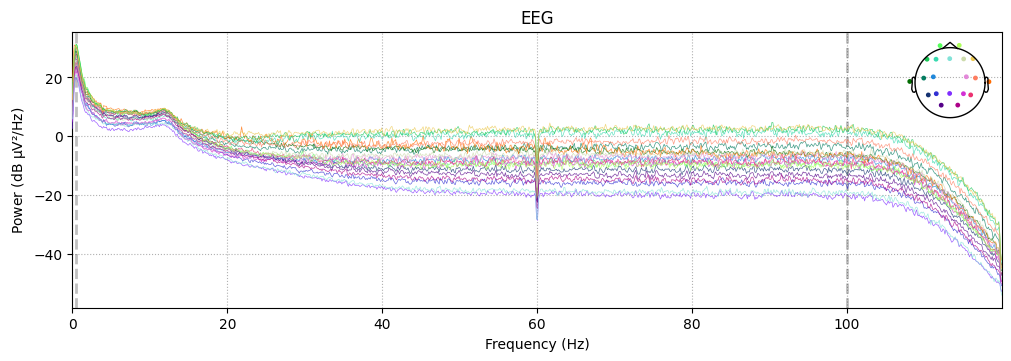

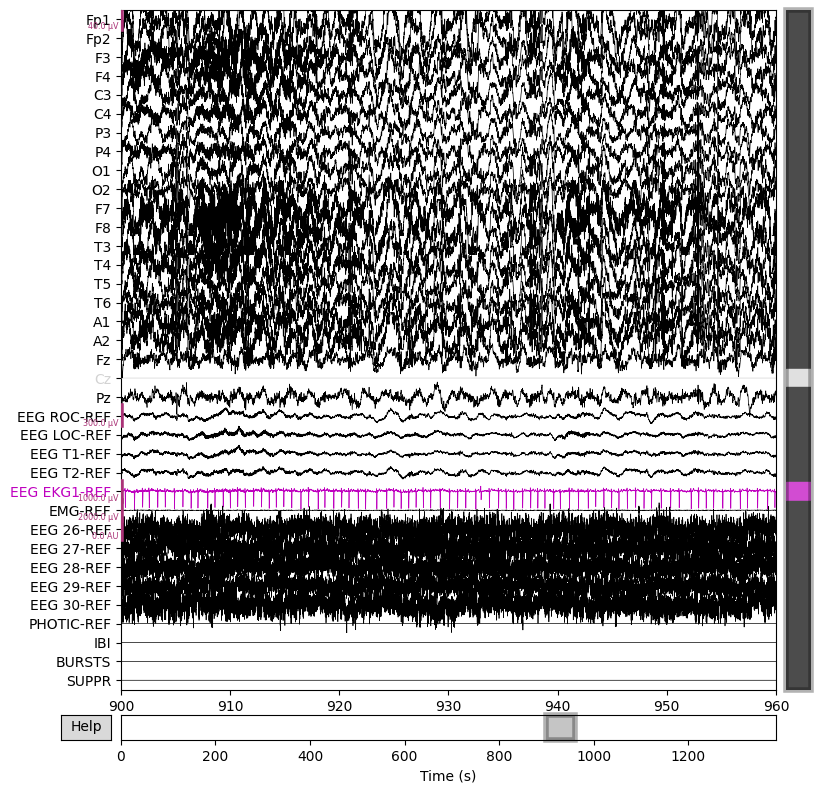

Storing preprocessed_eeg_dict as pickle


In [18]:
n_groups = len(files_raw)
n_recordings = max(len(files_raw[0]), len(files_raw[1]))

preprocessed_eeg_dict = {}
index = 0

mne.set_log_level("WARNING")

preprocessed_eeg_dict_file = "preprocessed_eeg_dict.pkl"
preprocessed_eeg_dict_file_path = INTERIM_DATA_DIR / preprocessed_eeg_dict_file


if Path.exists(preprocessed_eeg_dict_file_path):
    print("Loading preprocessed_eeg_dict")
    with open(preprocessed_eeg_dict_file_path, "rb") as pkl_rb_obj:
        preprocessed_eeg_dict = pickle.load(pkl_rb_obj)
else:
    for iGroup in range(n_groups):
        for iRecording in range(n_recordings):
            clear_output()

            print(f"iGroup: {iGroup+1}, iRecording: {iRecording+1}")

            # Load EDF file
            raw = mne.io.read_raw_edf(files_raw[iGroup][iRecording]).load_data()

            # Fix channel names
            raw = fix_channel_names(raw=raw)

            # Re-Reference
            ref_ch = ["Cz"]
            raw, ref_data = mne.set_eeg_reference(raw, ref_ch, copy=True)
            raw.info["bads"] = (
                ref_ch  # set ref channel as bad so it isn't included in the EEG picks
            )

            # filter EEG
            raw = filter_raw_eeg(raw=raw, l_freq=0.5, h_freq=100, powerline_freq=60)

            # Get epochs => DISABLED as only in a few recordings contain actual stimulation pulse trains!
            # epochs = get_epochs_from_photic_stimuli_train_events(raw=raw, stim_ch='PHOTIC-REF', pulse_train_duration_s=10, tmin=-0.2, tmax=10.5)

            # Plot
            if save_figs == True:
                with mne.viz.use_browser_backend("matplotlib"):
                    fig_psd = raw.compute_psd(fmax=120).plot(
                        picks="eeg", exclude="bads", amplitude=False
                    )
                    fig_raw = raw.plot(n_channels=len(raw.ch_names), start=15 * 60, duration=60)

                    fig_psd.savefig(
                        f"../reports/figures/snippet/psd_snippet_group{iGroup+1}_recording{iRecording}.png",
                        bbox_inches="tight",
                    )
                    fig_raw.savefig(
                        f"../reports/figures/snippet/eeg_snippet_group{iGroup+1}_recording{iRecording}.png",
                        bbox_inches="tight",
                    )

            # Add processed data to list
            preprocessed_eeg_dict[index] = {
                "Group": iGroup + 1,
                "Recording": iRecording + 1,
                "raw": raw,
            }  #'epochs': epochs}
            index = index + 1

    print(f"Storing preprocessed_eeg_dict as pickle: {preprocessed_eeg_dict_file_path}")
    with open(preprocessed_eeg_dict_file_path, "wb") as pkl_wb_obj:
        pickle.dump(preprocessed_eeg_dict, pkl_wb_obj)

print("Done")

# Time Frequency Analysis
Quick test for feature generation in the 2_ notebook

(129, 10)


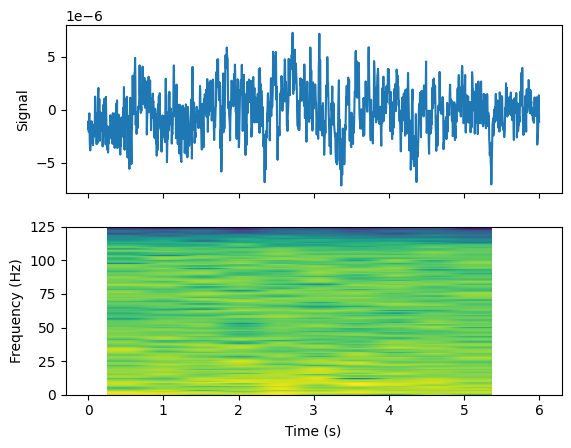

In [19]:
data, times = preprocessed_eeg_dict[3]["raw"].copy().crop(20 * 60, 20.1 * 60)[:]
x = data[7]

fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)

ax1.plot(times, x)
ax1.set_ylabel("Signal")

Fs = 250

Pxx, freqs, bins, im = ax2.specgram(x, Fs=Fs)
# The `specgram` method returns 4 objects. They are:
# - Pxx: the periodogram
# - freqs: the frequency vector
# - bins: the centers of the time bins
# - im: the .image.AxesImage instance representing the data in the plot
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Frequency (Hz)")
# ax2.set_xlim(0, 30)
print(Pxx.shape)
plt.show()

# ICA

{'eeg': np.float64(0.9904064895473363)}


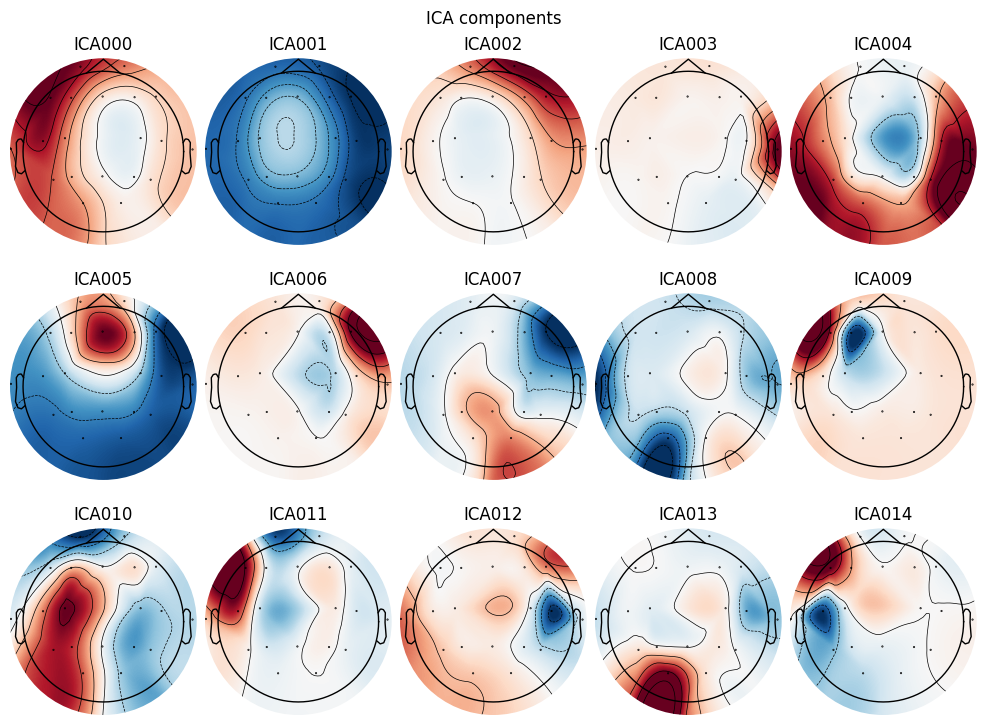

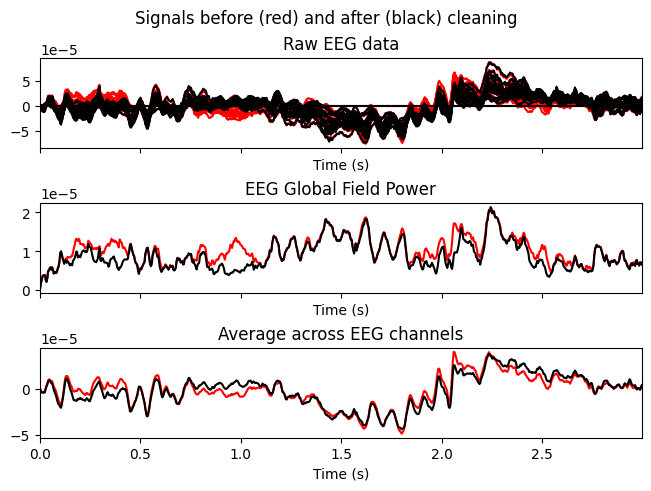

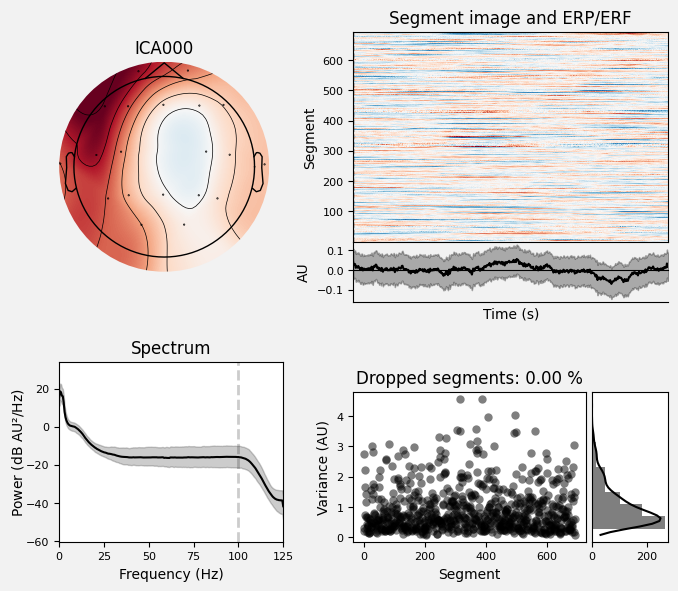

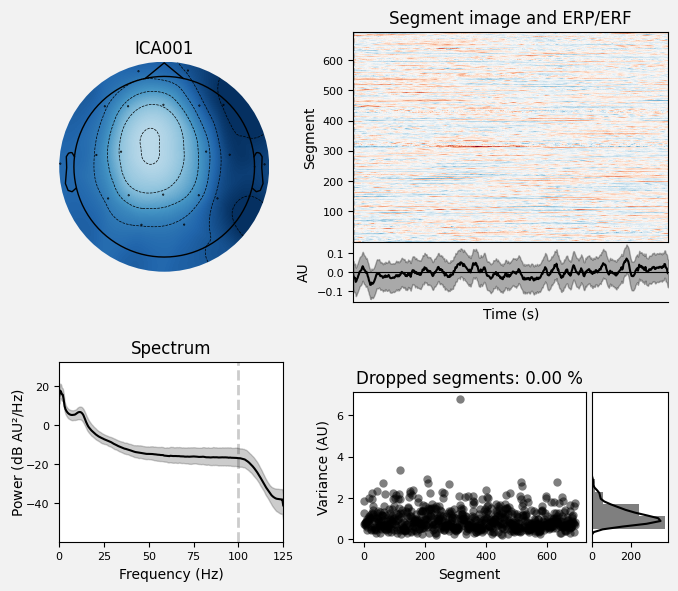

[<Figure size 700x600 with 6 Axes>, <Figure size 700x600 with 6 Axes>]

In [20]:
# ICA for components
ica = mne.preprocessing.ICA(n_components=15, max_iter="auto", random_state=97)
ica.fit(raw)
ica

# see explained variance
explained_var_ratio = ica.get_explained_variance_ratio(raw)
print(explained_var_ratio)

# visualize the components
# overview
ica.plot_components()

# blinks
ica.plot_overlay(raw, exclude=[0], picks="eeg")

# check properties
ica.plot_properties(raw, picks=[0, 1])